# Regions of Interest: Defining and Managing Spatial Regions

## Learning Objectives

By the end of this notebook, you will be able to:

- Define named regions of interest (ROIs) as points or polygons
- Add, remove, and update regions in an environment
- Query spatial relationships (bins in regions, distances to regions)
- Use regions for behavioral analysis (time in zone, entries/exits)
- Save and load region definitions with JSON serialization
- Visualize regions overlaid on environments

**Estimated time: 20-25 minutes**

## Why Regions of Interest?

In spatial navigation experiments, certain locations have special meaning:

- **Goal locations**: Reward sites, escape platforms, target zones
- **Start locations**: Where trials begin
- **Context zones**: Different areas with distinct features
- **Object locations**: Novel or familiar object positions
- **Danger zones**: Shock zones, predator areas

The `neurospatial` library lets you define these regions and use them for analysis:
- Mark important locations
- Compute behavioral metrics (time in zone, approaches)
- Visualize task structure
- Share experimental designs

Regions are **immutable** and **serializable** - perfect for reproducible science!

## Setup

In [1]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon as MPLPolygon
from shapely.geometry import Point, Polygon

from neurospatial import Environment
from neurospatial.regions import Regions

np.random.seed(42)
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams["font.size"] = 11

## Creating an Example Environment

Let's create a Morris water maze environment - a classic spatial memory task where rodents learn to find a hidden platform.

In [2]:
# Create circular water maze (120 cm diameter)
maze_center = Point(60, 60)
maze_radius = 60.0
maze_boundary = maze_center.buffer(maze_radius)

# Generate position data - animal searching for platform
n_samples = 2000

# Start from random edge locations (simulating starting positions)
start_angles = np.random.choice([0, 90, 180, 270], size=n_samples)
angles = np.deg2rad(start_angles + np.random.randn(n_samples) * 10)

# Create trajectory that gradually moves toward platform location (SW quadrant)
position_data = np.zeros((n_samples, 2))
position_data[0] = [
    60 + maze_radius * 0.9 * np.cos(angles[0]),
    60 + maze_radius * 0.9 * np.sin(angles[0]),
]

platform_location = np.array([30.0, 30.0])  # SW quadrant

for t in range(1, n_samples):
    # Random walk with bias toward platform
    to_platform = platform_location - position_data[t - 1]
    distance_to_platform = np.linalg.norm(to_platform)

    if distance_to_platform > 10:  # If far from platform
        # Weak attraction to platform + noise
        step = to_platform * 0.05 + np.random.randn(2) * 3.0
    else:  # Near platform - circle around it
        step = np.random.randn(2) * 1.0

    position_data[t] = position_data[t - 1] + step

    # Enforce circular boundary
    dist_from_center = np.linalg.norm(position_data[t] - np.array([60, 60]))
    if dist_from_center > maze_radius:
        # Bounce off wall
        direction = (position_data[t] - np.array([60, 60])) / dist_from_center
        position_data[t] = np.array([60, 60]) + direction * (maze_radius - 1)

print(f"Generated {len(position_data)} position samples")
print(f"Arena: {maze_radius * 2:.0f} cm diameter circular water maze")

Generated 2000 position samples
Arena: 120 cm diameter circular water maze


In [3]:
# Create environment
env = Environment.from_polygon(polygon=maze_boundary, bin_size=6.0, name="WaterMaze")

print(env.info())

Environment Information

Name: WaterMaze
Layout Type: ShapelyPolygon
Dimensions: 2
Number of Bins: 316

Spatial Extent:
  Dimension 0: [0.00, 120.00] (range: 120.00)
  Dimension 1: [0.00, 120.00] (range: 120.00)

Bin Sizes:
  Dimension 0: 6.00
  Dimension 1: 6.00

Regions: None



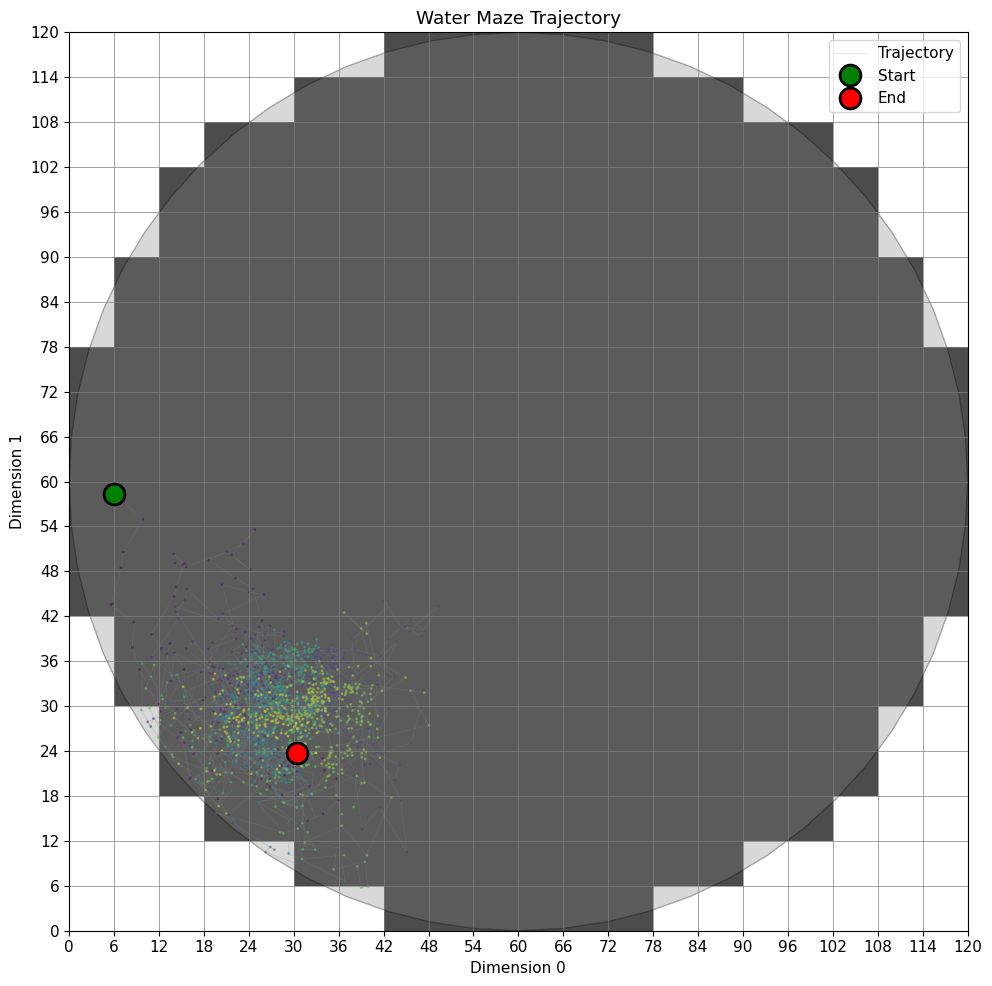

In [4]:
# Visualize trajectory
fig, ax = plt.subplots(figsize=(10, 10))

# Plot environment
env.plot(ax=ax, show_connectivity=False)

# Plot trajectory
ax.plot(
    position_data[:, 0],
    position_data[:, 1],
    "gray",
    alpha=0.3,
    linewidth=0.5,
    label="Trajectory",
)
ax.scatter(
    position_data[:, 0],
    position_data[:, 1],
    c=np.arange(len(position_data)),
    cmap="viridis",
    s=1,
    alpha=0.5,
)

# Mark start and end
ax.plot(
    position_data[0, 0],
    position_data[0, 1],
    "go",
    markersize=15,
    label="Start",
    markeredgecolor="black",
    markeredgewidth=2,
)
ax.plot(
    position_data[-1, 0],
    position_data[-1, 1],
    "ro",
    markersize=15,
    label="End",
    markeredgecolor="black",
    markeredgewidth=2,
)

ax.set_title("Water Maze Trajectory")
ax.set_aspect("equal")
ax.legend()
plt.tight_layout()
plt.show()

## Creating Regions: Point Regions

A **point region** represents a specific location. Let's define the platform location:

### Adding Regions to Environment

Environments have a `regions` attribute that works like a dictionary:

In [5]:
# Add the platform region
env.regions.add("platform", point=platform_location, metadata={"color": "red"})

# Check what regions exist
print(f"Regions in environment: {list(env.regions.keys())}")
print(f"Number of regions: {len(env.regions)}")

# Access a specific region
platform = env.regions["platform"]
print(f"\nPlatform region: {platform}")

Regions in environment: ['platform']
Number of regions: 1

Platform region: platform


### Adding Multiple Regions

Let's add start locations in each cardinal direction:

In [6]:
# Define start positions around the edge
start_positions = {
    "start_north": np.array([60.0, 110.0]),
    "start_east": np.array([110.0, 60.0]),
    "start_south": np.array([60.0, 10.0]),
    "start_west": np.array([10.0, 60.0]),
}

# Add all start positions
for name, point in start_positions.items():
    env.regions.add(name, point=point, metadata={"color": "green"})

print(f"Total regions: {len(env.regions)}")
print(f"Region names: {list(env.regions.keys())}")

Total regions: 5
Region names: ['platform', 'start_north', 'start_east', 'start_south', 'start_west']


### Visualizing Regions

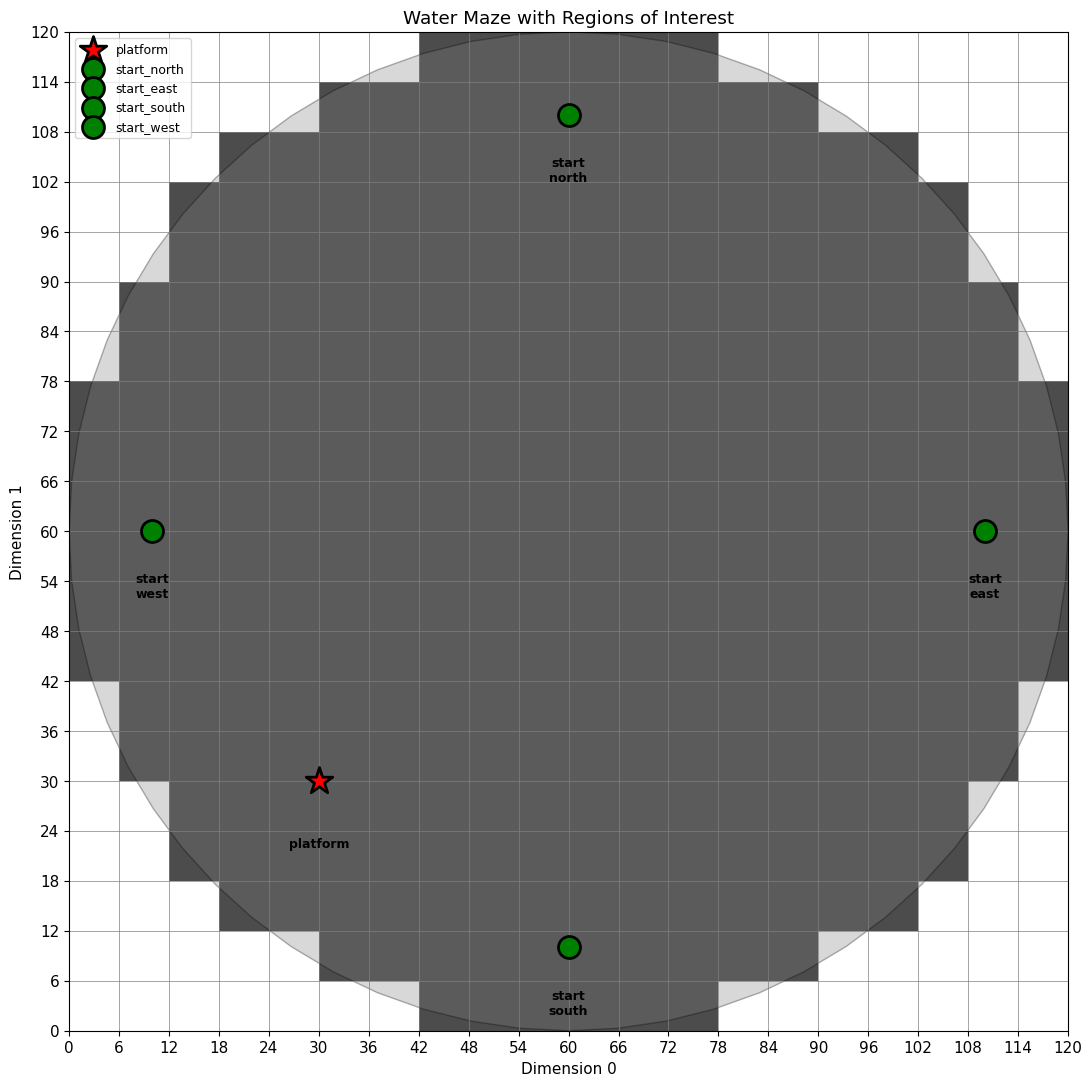

In [7]:
# Plot environment with regions
fig, ax = plt.subplots(figsize=(11, 11))

# Plot environment
env.plot(ax=ax, show_connectivity=False)

# Plot regions
for region_name, region in env.regions.items():
    if region.kind == "point":
        marker = "*" if "platform" in region_name else "o"
        size = 400 if "platform" in region_name else 250
        color = region.metadata.get("color", "blue") if region.metadata else "blue"
        ax.scatter(
            region.data[0],
            region.data[1],
            c=color,
            s=size,
            marker=marker,
            edgecolors="black",
            linewidth=2,
            label=region_name,
            zorder=10,
        )
        # Add text label
        ax.text(
            region.data[0],
            region.data[1] - 8,
            region_name.replace("_", "\n"),
            ha="center",
            fontsize=9,
            fontweight="bold",
        )

ax.set_title("Water Maze with Regions of Interest")
ax.set_aspect("equal")
ax.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

## Creating Regions: Polygon Regions

**Polygon regions** define areas (zones) rather than points. Let's define quadrants of the maze:

In [8]:
# Define quadrants as simple box polygons
nw_quadrant = Polygon([(60, 60), (60, 120), (0, 120), (0, 60), (60, 60)])
ne_quadrant = Polygon([(60, 60), (120, 60), (120, 120), (60, 120), (60, 60)])
sw_quadrant = Polygon([(60, 60), (0, 60), (0, 0), (60, 0), (60, 60)])
se_quadrant = Polygon([(60, 60), (60, 0), (120, 0), (120, 60), (60, 60)])

# Intersect with maze boundary to get actual quadrants
nw_zone = maze_boundary.intersection(nw_quadrant)
ne_zone = maze_boundary.intersection(ne_quadrant)
sw_zone = maze_boundary.intersection(sw_quadrant)
se_zone = maze_boundary.intersection(se_quadrant)

# Add quadrant regions
env.regions.add("quadrant_NW", polygon=nw_zone, metadata={"color": "lightblue"})
env.regions.add("quadrant_NE", polygon=ne_zone, metadata={"color": "lightgreen"})
env.regions.add("quadrant_SW", polygon=sw_zone, metadata={"color": "lightcoral"})
env.regions.add("quadrant_SE", polygon=se_zone, metadata={"color": "lightyellow"})

print(f"Total regions: {len(env.regions)}")
print(
    f"Polygon regions: {[name for name, r in env.regions.items() if r.kind == 'polygon']}"
)

Total regions: 9
Polygon regions: ['quadrant_NW', 'quadrant_NE', 'quadrant_SW', 'quadrant_SE']


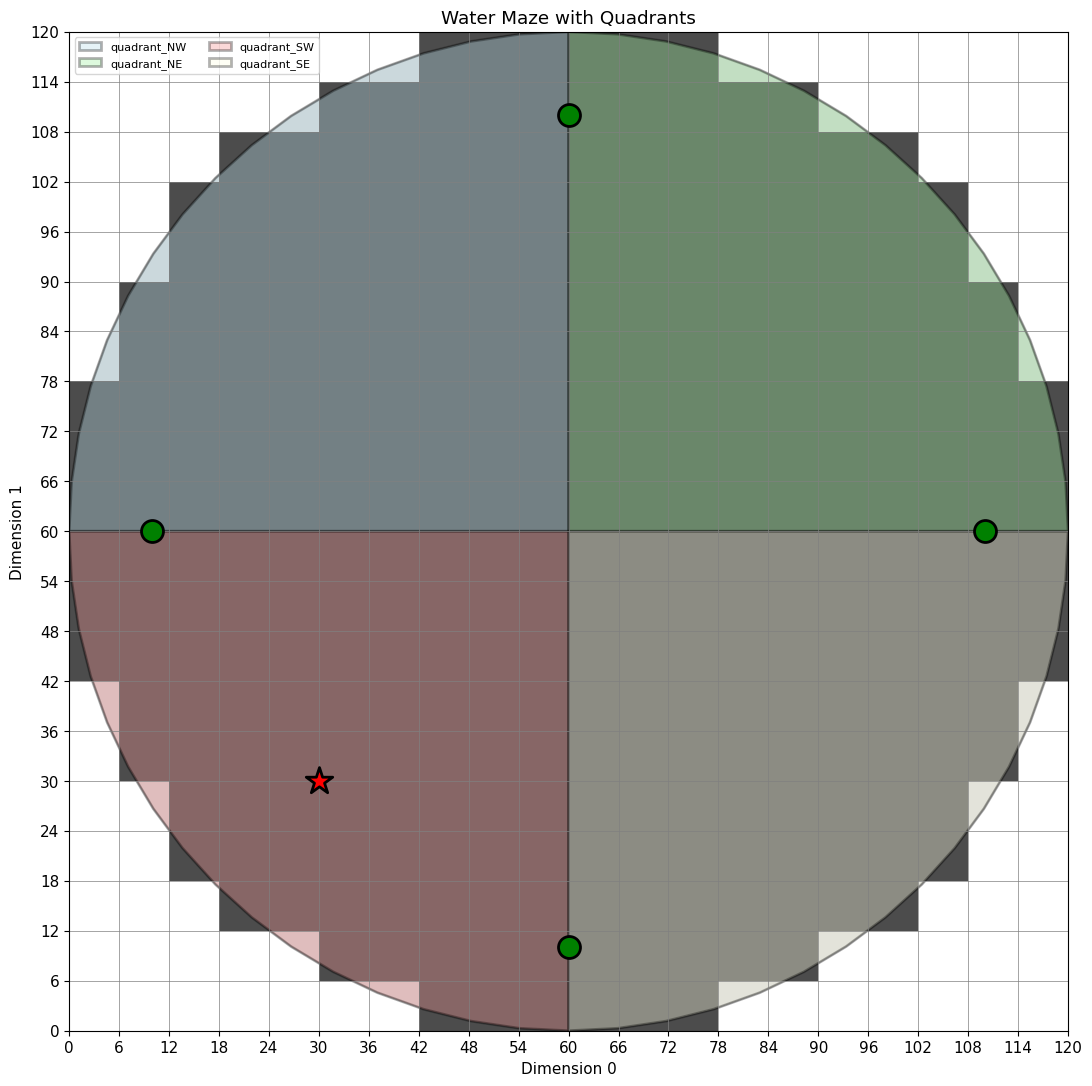

In [9]:
# Visualize quadrants
fig, ax = plt.subplots(figsize=(11, 11))

# Plot environment
env.plot(ax=ax, show_connectivity=False)

# Plot polygon regions first
for region_name, region in env.regions.items():
    if region.kind == "polygon" and region.data.geom_type == "Polygon":
        coords = np.array(region.data.exterior.coords)
        color = (
            region.metadata.get("color", "lightblue")
            if region.metadata
            else "lightblue"
        )
        patch = MPLPolygon(
            coords,
            facecolor=color,
            alpha=0.3,
            edgecolor="black",
            linewidth=2,
            label=region_name,
        )
        ax.add_patch(patch)

# Plot point regions on top
for region_name, region in env.regions.items():
    if region.kind == "point":
        marker = "*" if "platform" in region_name else "o"
        size = 400 if "platform" in region_name else 250
        color = region.metadata.get("color", "blue") if region.metadata else "blue"
        ax.scatter(
            region.data[0],
            region.data[1],
            c=color,
            s=size,
            marker=marker,
            edgecolors="black",
            linewidth=2,
            zorder=10,
        )

ax.set_title("Water Maze with Quadrants")
ax.set_aspect("equal")
ax.legend(loc="upper left", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

## Querying Regions

Now let's use regions for analysis!

### Finding Bins in a Region

In [10]:
# Get bins in target quadrant
target_quadrant = env.regions["quadrant_SW"]

# Find which bins are in this region
bins_in_target = []
for bin_idx in range(env.n_bins):
    bin_center = env.bin_centers[bin_idx]
    point = Point(bin_center[0], bin_center[1])
    if target_quadrant.data.contains(point):
        bins_in_target.append(bin_idx)

print(f"Bins in target quadrant (SW): {len(bins_in_target)} / {env.n_bins} total")
print(f"Percentage: {len(bins_in_target) / env.n_bins * 100:.1f}%")

Bins in target quadrant (SW): 79 / 316 total
Percentage: 25.0%


### Computing Time in Zone

A key behavioral metric: how much time did the animal spend in each quadrant?

In [11]:
# Compute time in each quadrant
dt = 0.05  # 50 ms per sample

quadrant_names = ["quadrant_NW", "quadrant_NE", "quadrant_SW", "quadrant_SE"]
time_in_zone = {}

for quad_name in quadrant_names:
    quad_polygon = env.regions[quad_name].data

    # Check which samples are in this quadrant
    samples_in_quad = 0
    for pos in position_data:
        point = Point(pos[0], pos[1])
        if quad_polygon.contains(point):
            samples_in_quad += 1

    time_in_zone[quad_name] = samples_in_quad * dt
    print(
        f"{quad_name}: {time_in_zone[quad_name]:.1f} seconds ({samples_in_quad} samples)"
    )

total_time = sum(time_in_zone.values())
print(f"\nTotal time: {total_time:.1f} seconds")

# Check if animal learned
target_time = time_in_zone["quadrant_SW"]
target_percentage = target_time / total_time * 100
print(f"\nTime in target quadrant: {target_percentage:.1f}%")
print("Chance level: 25%")
if target_percentage > 35:
    print("Result: Animal shows spatial memory!")
else:
    print("Result: No clear preference yet")

quadrant_NW: 0.0 seconds (0 samples)
quadrant_NE: 0.0 seconds (0 samples)
quadrant_SW: 100.0 seconds (2000 samples)
quadrant_SE: 0.0 seconds (0 samples)

Total time: 100.0 seconds

Time in target quadrant: 100.0%
Chance level: 25%
Result: Animal shows spatial memory!


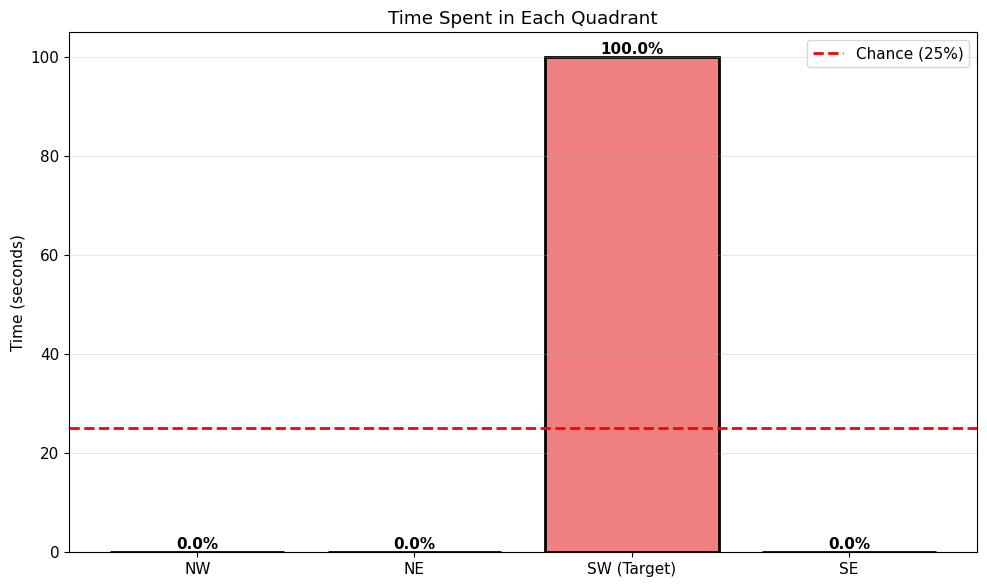

In [12]:
# Visualize time in zone
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["lightblue", "lightgreen", "lightcoral", "lightyellow"]
quadrant_labels = ["NW", "NE", "SW (Target)", "SE"]
times = [time_in_zone[name] for name in quadrant_names]

bars = ax.bar(quadrant_labels, times, color=colors, edgecolor="black", linewidth=2)

# Add chance level line
ax.axhline(
    total_time / 4, color="red", linestyle="--", linewidth=2, label="Chance (25%)"
)

ax.set_ylabel("Time (seconds)")
ax.set_title("Time Spent in Each Quadrant")
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Add percentage labels on bars
for bar, time in zip(bars, times, strict=False):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{time / total_time * 100:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

### Distance to Region

Compute distances from all bins to a specific region:

In [13]:
# Compute distance from each bin to platform
platform_point = env.regions["platform"].data

distances_to_platform = np.zeros(env.n_bins)
for bin_idx in range(env.n_bins):
    bin_center = env.bin_centers[bin_idx]
    distances_to_platform[bin_idx] = np.linalg.norm(bin_center - platform_point)

print(f"Min distance to platform: {distances_to_platform.min():.1f} cm")
print(f"Max distance to platform: {distances_to_platform.max():.1f} cm")
print(f"Mean distance to platform: {distances_to_platform.mean():.1f} cm")

Min distance to platform: 4.2 cm
Max distance to platform: 101.9 cm
Mean distance to platform: 54.6 cm


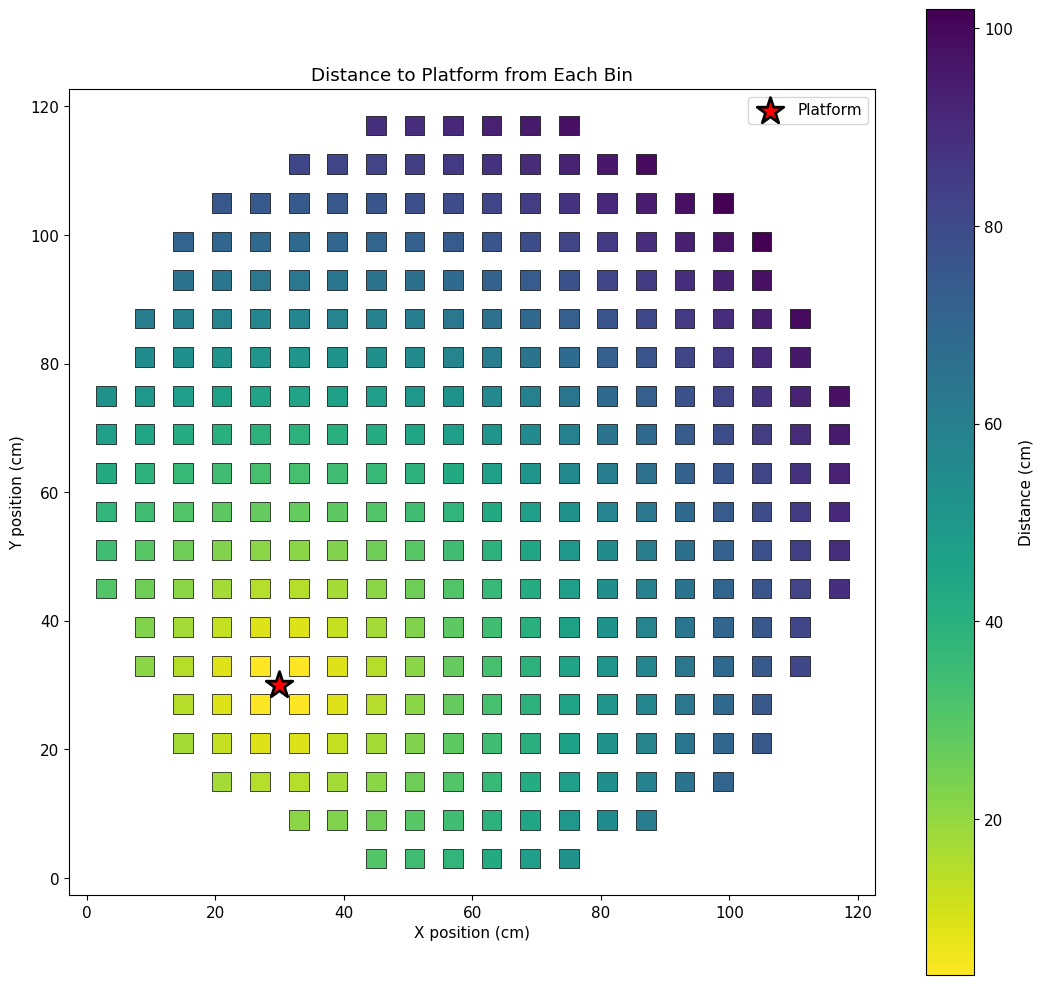

In [14]:
# Visualize distance map
fig, ax = plt.subplots(figsize=(11, 10))

scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=distances_to_platform,
    s=200,
    cmap="viridis_r",
    marker="s",
    edgecolors="black",
    linewidth=0.5,
)

ax.scatter(
    platform_point[0],
    platform_point[1],
    c="red",
    s=400,
    marker="*",
    edgecolors="black",
    linewidth=2,
    label="Platform",
    zorder=10,
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Distance to Platform from Each Bin")
ax.set_aspect("equal")
ax.legend()
plt.colorbar(scatter, ax=ax, label="Distance (cm)")
plt.tight_layout()
plt.show()

## Region Operations

Regions support several useful operations:

### Getting Region Center

In [15]:
# Get center of target quadrant
target_center = env.regions.region_center("quadrant_SW")
print(f"Center of SW quadrant: {target_center}")
print(f"Platform location: {platform_point}")
print(f"Distance: {np.linalg.norm(target_center - platform_point):.1f} cm")

Center of SW quadrant: [34.55566547 34.55566547]
Platform location: [30. 30.]
Distance: 6.4 cm


### Computing Region Area

In [16]:
# Compute area of each quadrant
for quad_name in quadrant_names:
    area = env.regions.area(quad_name)
    print(f"{quad_name}: {area:.0f} cm²")

areas = [env.regions.area(name) for name in quadrant_names]
print(f"\nMean quadrant area: {np.mean(areas):.0f} cm²")

quadrant_NW: 2823 cm²
quadrant_NE: 2823 cm²
quadrant_SW: 2823 cm²
quadrant_SE: 2823 cm²

Mean quadrant area: 2823 cm²


### Buffering Regions

In [17]:
# Create platform zone
platform_zone = env.regions.buffer("platform", distance=10.0, new_name="platform_zone")
print(f"Platform zone area: {platform_zone.data.area:.0f} cm²")

Platform zone area: 314 cm²


## Saving and Loading Regions

In [18]:
# Create temporary file path
temp_fd, temp_path = tempfile.mkstemp(suffix=".json")
os.close(temp_fd)  # Close the file descriptor

# Save regions
env.regions.to_json(temp_path)
print(f"Regions saved to: {temp_path}")

# Load regions
loaded_regions = Regions.from_json(temp_path)
print(f"Loaded {len(loaded_regions)} regions")

Path(temp_path).unlink()

Regions saved to: /var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/tmpnegz5wem.json
Loaded 10 regions


## Common Pitfalls

### Pitfall 1: Trying to modify immutable regions

In [19]:
# Regions are immutable - demonstrating the correct approach
# Note: Regions are immutable - can't modify .data directly
# Must use update_region() to modify

env.regions.update_region("platform", point=np.array([50, 50]))
print("Updated platform location successfully using update_region()")

Updated platform location successfully using update_region()


### Pitfall 2: Trying to overwrite existing regions

In [20]:
# Cannot overwrite existing regions - must use update_region() or delete first
# Correct approach: use update_region()
env.regions.update_region("platform", point=np.array([50, 50]))
print("Updated region successfully using update_region()")

Updated region successfully using update_region()


## Key Takeaways

1. **Regions define important locations** - platforms, goals, zones
2. **Two region types**: Point regions and Polygon regions
3. **Use for behavioral analysis**: Time in zone, distance to goal
4. **Regions are immutable** - use `update_region()` to modify
5. **Dictionary-like interface**: `add()`, `remove()`, `keys()`
6. **Serialization support** - save/load from JSON
7. **Operations**: `buffer()`, `area()`, `region_center()`

## Next Steps

In the next notebook (**05_track_linearization.ipynb**), you'll learn:
- 1D linearized tracks with GraphLayout
- Converting between N-D and linear coordinates
- Plus maze analysis example

## Exercises (Optional)

1. Define regions for a radial arm maze
2. Compute average latency to first platform zone entry
3. Create heatmap of bins visited before reaching platform
4. Design a T-maze with choice zones